<a href="https://colab.research.google.com/github/Rohit1217/MADE/blob/main/made.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch,torchvision
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms


In [2]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)

data_target=data*0.5+0.5
data_target
data=data.view(60000,784)
data=data.to(dtype=torch.float32)
data_target=data_target.view(60000,784)
#new_column = torch.full((60000, 1), 0)
#data = torch.cat((new_column, data[:, :-1]), dim=1)

trainset=TensorDataset(data,data_target)
trainloader=DataLoader(trainset,batch_size=256,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 201303968.61it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30065945.35it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 84528782.49it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19223540.63it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [3]:
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False)
data_t=testset.data
data_t=data_t.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data_t=norm(data_t)
data_t=data_t.view(10000,784)
new_column = torch.full((10000, 1), 2)
data_t = torch.cat((new_column, data_t[:, :-1]), dim=1)

In [4]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def masker(mask):
  out,inn=mask.shape
  stride=inn/out
  for i in range(out):

    for j in range(inn):
      if j>=(i)*stride:
        mask[i,j]=0
  return mask
x=torch.ones(5,5)
masker(x)

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]])

In [6]:
def mask(inn,out):
  mask=torch.ones(out,inn)
  return masker(mask)
#mask(5,5)

In [7]:
class MaskedLinear(nn.Module):
  def __init__(self,in_dim,out_dim):
    super(MaskedLinear,self).__init__()
    self.fc=nn.Linear(in_dim,out_dim)
    self.mask1=mask(in_dim,out_dim).to(get_device())
    self.register_buffer('mask',self.mask1)

  def forward(self,x):
    self.fc.weight.data*=self.mask
    return self.fc(x)


In [124]:
class Made(nn.Module):
  def __init__(self,latent_dim):
    super(Made,self).__init__()
    self.ldim=latent_dim
    self.fc1=MaskedLinear(784,latent_dim)
    self.ln1=nn.LayerNorm(latent_dim)
    self.fc2=MaskedLinear(latent_dim,784)
    self.ln2=nn.LayerNorm(784)
    self.ln3=nn.LayerNorm(784)
    self.fc3=MaskedLinear(784,784)
    self.fc4=MaskedLinear(784,784)
    self.fc5=MaskedLinear(784,784)

  def forward(self,x):
    #x=x+torch.arange(784).to(get_device())
    x=(F.relu(self.fc1(x)))
    x=(F.relu(self.fc2(x)))
    x=(F.relu(self.fc3(x)))
    x=F.relu(self.fc4(x))
    x=self.fc5(x)
    return x

In [125]:
lr_rate=0.001
epochs=100
model=Made(784)
model.to(get_device())
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=lr_rate)

In [126]:
loss_list=[]
for epoch in range(epochs):
  total_loss=0
  length=0
  for input,target in trainloader:
    input,target=input.to(get_device()),target.to(get_device())
    pred=F.sigmoid(model(input))
    loss=criterion(pred,target)

    total_loss+=loss.item()
    length+=1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'total_loss ={total_loss},avg_loss={total_loss/length},epoch={epoch}')

total_loss =73.94883427023888,avg_loss=0.3146758905116548,epoch=0
total_loss =55.4858982861042,avg_loss=0.23611020547278383,epoch=1
total_loss =51.41676799952984,avg_loss=0.21879475744480784,epoch=2
total_loss =48.88380543887615,avg_loss=0.2080161933569198,epoch=3
total_loss =46.57390131056309,avg_loss=0.1981868140875025,epoch=4
total_loss =44.345501750707626,avg_loss=0.18870426276896862,epoch=5
total_loss =42.648530185222626,avg_loss=0.18148310717116012,epoch=6
total_loss =41.11115038394928,avg_loss=0.17494106546361396,epoch=7
total_loss =39.651152566075325,avg_loss=0.1687283087918099,epoch=8
total_loss =38.6245292276144,avg_loss=0.16435969884091237,epoch=9
total_loss =37.75796124339104,avg_loss=0.16067217550379165,epoch=10
total_loss =36.97546899318695,avg_loss=0.15734242124760406,epoch=11
total_loss =36.350430488586426,avg_loss=0.154682682930155,epoch=12
total_loss =35.8129917383194,avg_loss=0.1523957095247634,epoch=13
total_loss =35.366165578365326,avg_loss=0.1504943216100652,epoch

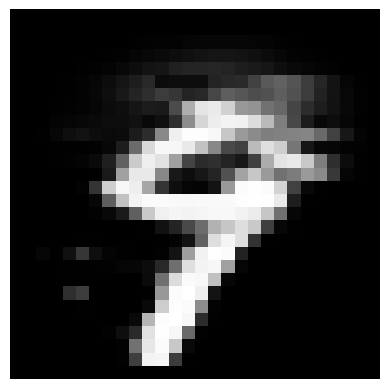

In [127]:
model.eval()
with torch.no_grad():
  x=data_t[9]
  #x[0]=0
  #x=torch.rand(784)
  x=x.to('cuda:0')
  x=F.sigmoid(model(x))
    #print(x[28*14:28*15])

  x=x.view(28,28)
  x=x.to('cpu')
  image_np = x.numpy()



  # Display the image using matplotlib
  plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
  plt.axis('off')  # Turn off axis labels
  plt.show()

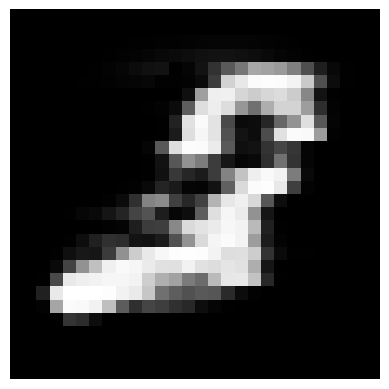

In [149]:
model.eval()
with torch.no_grad():
  x=torch.zeros(784)
  z=torch.zeros(784)
  #z=z.to('cuda:0')
  x=x.to(get_device())
  y=torch.zeros(784)
  y=y.to(get_device())
  j=0
  y[:j]=data_t[9,:j]
  for i in range(784):
    if i>j:
      y[i]=x[i]
      #print(y[:i])
      x=F.sigmoid(model(y))
      if i<783:
          x=torch.bernoulli(x.float())
      #print(x[:i])
      x=2*x-1
      #x=torch.bernoulli(x.float())

x=0.5*x+0.5
z=z.view(28,28)
x=x.view(28,28)
x=x.to('cpu')
image_np = x.numpy()

# Display the image using matplotlib
plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()


In [ ]:
with torch.no_grad():
    # Function to generate an image iteratively
    def generate_image(model, initial_pixel=2, image_size=784):
        # Initialize x with a single pixel
        x = torch.tensor([[initial_pixel]])

        # Move the tensor to the appropriate device
        x = x.to(get_device())
        x=x.to(dtype=torch.float32)
        # Generate pixels iteratively
        for i in range(1, image_size):
            x_probs = F.sigmoid(model(x))
            sampled_pixel=x_probs[0,i-1]
            #print(x_probs)
            #sampled_pixel = torch.bernoulli(x_probs[0,i-1])
            #print(x_probs,sampled_pixel,x_probs[0,i-1]
            #print(x,x.shape,sampled_pixel)
            x = torch.cat([x, sampled_pixel.unsqueeze(1)], dim=1)

            if i%30==0:
                #print(x)
                pass

        # Reshape and convert to numpy for visualization
        x = x.view(28, 28).detach().cpu().numpy()

        return x

    # Generate image iteratively starting with initial pixel 257
    generated_image = generate_image(model)

    # Display the sampled image using matplotlib
    plt.imshow(generated_image, cmap='gray')  # 'gray' colormap is used for grayscale images
    plt.axis('off')  # Turn off axis labels
    plt.show()
